In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)
    

Num GPUs Available:  1
2.13.0


In [2]:
# Инструменты для работы с массивами
import numpy as np

# Системные инструменты
import random, os, shutil   #, gdown
from time import time

# Основа для модели нейронной сети
from tensorflow.keras.models import Model

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Дополнительные утилиты keras
import keras.utils as image

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image

# функции для детализации и управления процессом обучения
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Open Source Computer Vision Library, библиотека компьютерного зрения с открытым исходным кодом
import cv2

# Библиотека для работыс csv
import pandas as pd

# Загрузка библиотек для работы с графиками
from matplotlib import pyplot as plt
%matplotlib inline

# Модули работы с изображениями
from PIL import Image, ImageDraw, ImageFont

# Создание случайных величин
from random import randint

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Названия подкаталогов
MAIN_DIR = '/mnt/e/UbuntuBackup/Carpets_Validate'
Data_Dir = '/mnt/e/UbuntuBackup/Carpets_Validate/AB_Dataset/'
IMG_DIR = Data_Dir+'Image'
IMG_SRC = MAIN_DIR+'/Images'
SUBST_DIR = Data_Dir+'Substracted'
MASK_DIR = Data_Dir+'Mask'
HEIGHT = 360
WIDTH = 640
# Минимальное количество символов для нумерации кадров
Min_Digits = 6

# Количество кадров для принудительного прыжка cv2.CAP_PROP_POS_FRAMES
JumpStep = 0

# Коэффициент мастаба эллипса (2 - вписан в BBox)
D_Coeff = 2

# Цвета эллипсов для различных размеров ковров
COLORS_LIST = [(255,0,0),
               (0,255,0),
               (0,0,255),
               (0,255,255),
               (255,0,255),
               (255,255,0)]

LABEL_SET = ['Labels_in_Folders/Batch_BO_13-05_left_bbm.csv','Labels_in_Folders/Batch_BO_13-05_left_bbm.csv']
LABELS = ['kover6090', 'kover85150', 'kover115200', 'kover150300', 'kover115400']

# Грузим Dataset

In [19]:
def check_class(lbl1,lbl2):
    for s in lbl2:
        if s not in lbl1:
            lbl1.append(s)
    return lbl1

def make_subst(cur_f):
    cur_num = int(cur_f[-10:-4])
    prev_f = cur_f[:-10]+f'{cur_num-1:06d}'+'.png'
#    print(cur_f,'=>',prev_f)
    cur_img = cv2.imread(os.path.join(IMG_SRC,cur_f[:-11],cur_f))
    prev_img = cv2.imread(os.path.join(IMG_SRC,cur_f[:-11],prev_f))
    dif = cv2.absdiff(cv2.cvtColor(cur_img, cv2.COLOR_BGR2GRAY),cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY))
    return dif

def add_mask(prev_f,cur_f,width,height,xmin,ymin,xmax,ymax,f_class):
    global mask
    if prev_f != cur_f:
        mask = np.zeros((height,width,3), np.uint8)
    cv2.ellipse(mask,(xmin, ymin),(int(abs(xmax-xmin)/D_Coeff), int(abs(ymax-ymin)/D_Coeff)), 0, 0, 360,COLORS_LIST[LABELS.index(f_class)], -1)
    return mask
    

In [20]:
labels_all = []
# проверяем существование каталогов
if False:'''
if not os.path.isdir(Data_Dir):
    os.mkdir(Data_Dir)
if not os.path.isdir(IMG_DIR):
    os.mkdir(IMG_DIR)
if not os.path.isdir(SUBST_DIR):
    os.mkdir(SUBST_DIR)
if not os.path.isdir(MASK_DIR):
    os.mkdir(MASK_DIR)
    '''
if  os.path.isdir(Data_Dir):
    shutil.rmtree(Data_Dir)
os.mkdir(Data_Dir)
os.mkdir(IMG_DIR)
os.mkdir(SUBST_DIR)
os.mkdir(MASK_DIR)

prev_file = ''    
for csv in LABEL_SET:
    df = pd.read_csv(os.path.join(MAIN_DIR,csv),sep=',')
    labels = df['class'].unique()
    labels_all = check_class(labels_all,labels)
    for index,row in df.iterrows():
        file = row.filename
        sub = make_subst(file)
        if file != prev_file:
            cv2.imwrite(os.path.join(SUBST_DIR,file),sub)
#           shutil.copy(os.path.join(IMG_SRC,file[:-11],file),IMG_DIR)
        cur_f = cv2.imread(os.path.join(IMG_SRC,file[:-11],file))
        cur_f = cv2.resize(cur_f, (WIDTH, HEIGHT),cv2.INTER_LINEAR)
        cv2.imwrite(os.path.join(IMG_DIR,file),cur_f)
        mask = add_mask(prev_file,file,row.width,row.height,row.xmin,row.ymin,row.xmax,row.ymax,row['class'])
        cv2.imwrite(os.path.join(MASK_DIR,file),mask)
        prev_file = file
        bbox = [row.xmin,row.ymin,row.xmax,row.ymax]
print(labels_all)

['kover115200', 'kover85150', 'kover6090', 'kover150300']


# Unet

In [4]:
# Глобальные параметры
IMG_W = 640           # Ширина картинки
IMG_H = 360           # Высота картинки
MAIN_DIR = '/mnt/e/UbuntuBackup/Carpets_Validate/AB_Dataset/'
IMG_SUBDIR = 'Image'
MASK_SUBDIR = 'Mask'
SUBST_SUBDIR = 'Substracted'
STEP = 10             # Шаг деления выборок

# Цвета пикселов сегментированных изображений RGB
CARPET0 = (255, 0, 0)           # Ковер 60*90 (красный)
CARPET1 = (0,255,0)		# Ковер 85*150 (зеленый)
CARPET2 = (0,0,255)		# Ковер 115*200 (синий)
CARPET3 = (0,255,255)		# Ковер 150*300 (голубой)
CARPET4 = (255,0,255)		# Ковер 115*400 (фиолетовый)
#CARPET5 = (255,255,0)		# Ковер х*х (желтый)
OTHER = (0, 0, 0)               # Остальное (черный)

CLASS_LABELS = (OTHER, 
                CARPET0, 
                CARPET1, 
                CARPET2, 
                CARPET3,
                CARPET4, 
#                CARPET5
                )
CLASS_COUNT = len(CLASS_LABELS)      # Количество классов на изображении

In [5]:
# Модель нейронной сети
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

# Обработка данных для подачи в нейронную сеть

Для начала создаем список имеющихся у нас файлов и разделим их на обучающую и валидационную выборки.

In [6]:
# Служебная функция распределения изображений по выборкам
def images_lists(MainFolder,   # имя основной папки
                 step,         # Шаг деления выборок
                 ):

    # Cписок имен файлов обучающей выборки
    files_train = []

    # Cписок имен файлов валидационной выборки
    files_val = []

    # Отметка текущего времени
    cur_time = time()

    i = 0
    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{MainFolder}/{IMG_SUBDIR}')):
        i += 1
        if i%step != 0:
          files_train.append(filename)
        else:
          files_val.append(filename)

    # Вывод времени загрузки картинок выборки
    print('Изображения загружены. Время загрузки: {:.2f} с'.format(time() - cur_time))

    # Вывод количества элементов в выборке
    print('{} изображений в обучающей выборке и {} в проверочной:'.format(len(files_train),len(files_val)))

    return files_train, files_val

# Функция возвращающая изображение по имени файла и соответствующему каталогу
def return_image(filename, sub_dir):
    return image.load_img(os.path.join(f'{MAIN_DIR}/{sub_dir}', filename),
                          target_size=(IMG_H, IMG_W))

# Функция возвращающая Ч/Б изображение по имени файла и соответствующему каталогу
def return_grayscale_image(filename, sub_dir):
    image = cv2.imread(os.path.join(f'{MAIN_DIR}/{sub_dir}', filename),cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_W, IMG_H), interpolation = cv2.INTER_LINEAR)
    return image

# Функция для просмотра изображений из набора
def show_imageset(files_list,  # выборка изображений
                  subdir,      # подкаталог изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n):
        img = return_image(random.choice(files_list), subdir)  # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                     # Отображение картинки

    plt.show()                                                 # Отрисовка изображений

Изображения загружены. Время загрузки: 0.01 с
2877 изображений в обучающей выборке и 319 в проверочной:


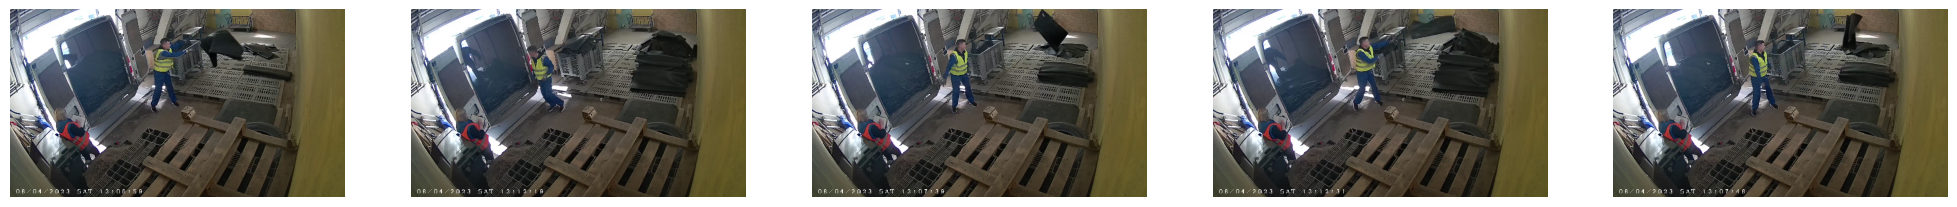

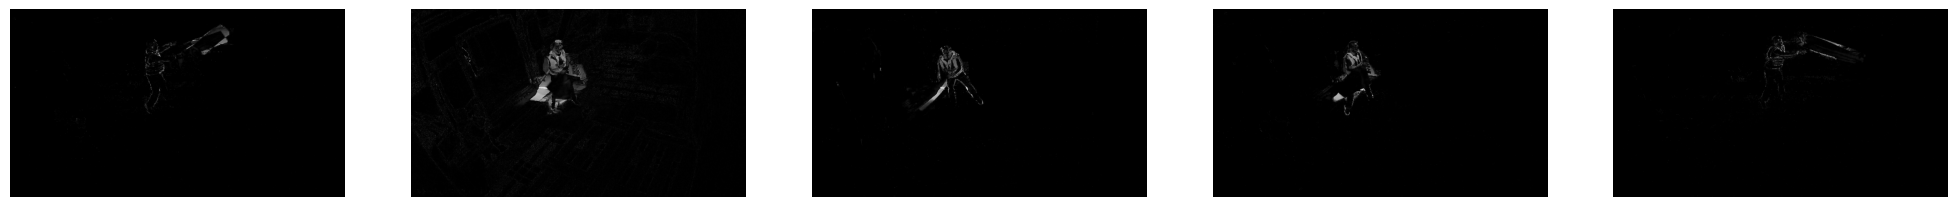

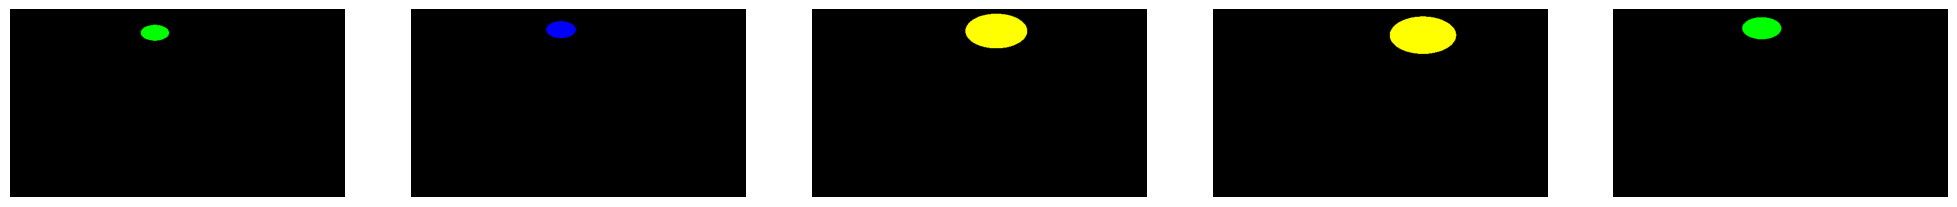

In [7]:
# Получение списков файлов
Files_Train, Files_Val = images_lists(MAIN_DIR, 10)

# Просмотр оригинальный изображений из обучающего набора
show_imageset(Files_Train, IMG_SUBDIR, 5)

# Просмотр входных изображений из обучающего набора
show_imageset(Files_Train, SUBST_SUBDIR, 5)

# Просмотр сегментированных изображений из обучающего набора
show_imageset(Files_Train, MASK_SUBDIR, 5)

Чтобы уменьшить объем данных преобразуем цветные маски в массив содержащий вместо цвета пикселя номер соответствующего класса.

In [8]:
# Функция преобразования цветного сегментированного изображения в метки классов
def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_H, IMG_W, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

# Функция преобразования тензора меток класса в цветное сегметрированное изображение
def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_H, IMG_W, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)

    return np.array(result)

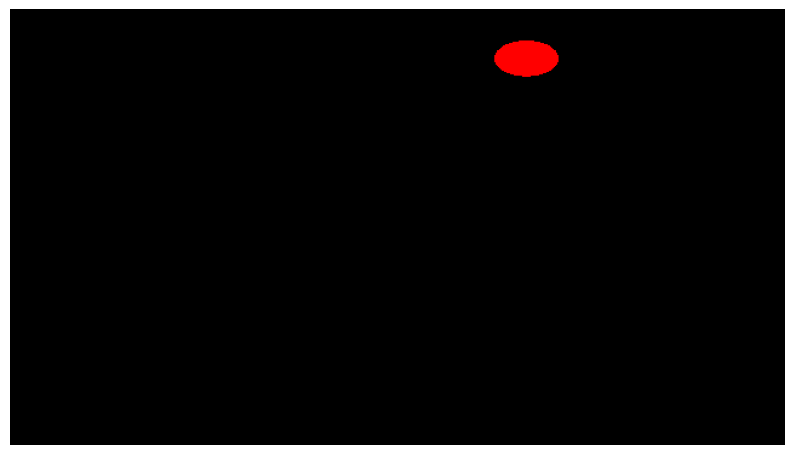

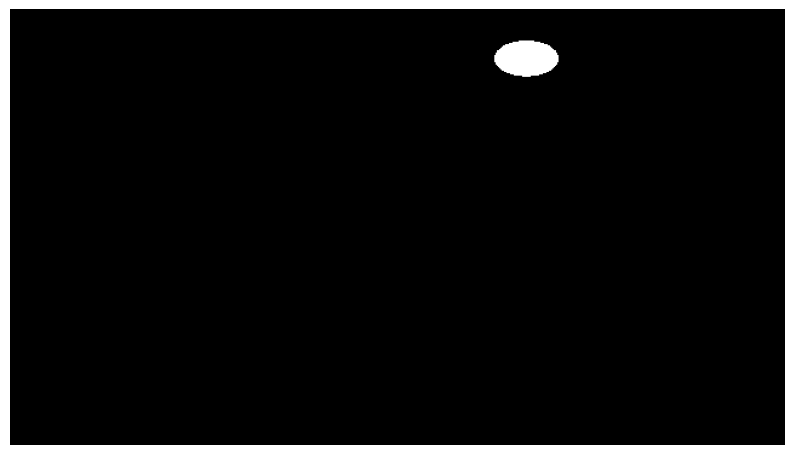

In [9]:
# Передпросмотр маски изображения
z = random.randint(0,len(Files_Train))
sample = np.array(return_image(Files_Train[z], MASK_SUBDIR))

plt.figure(figsize=(10, 6))
plt.imshow(sample)
plt.axis('off')
plt.show()

# Нулевой тензор
y = np.zeros((IMG_H, IMG_W, 1), dtype='uint8')

# Заполняем пикселы по цветам классов метками классов в выходном тензоре
for i, cl in enumerate(CLASS_LABELS):
    y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

# Выводим результат
plt.figure(figsize=(10, 6))
plt.imshow(y[..., 0], cmap='gray')
plt.axis('off')
plt.show()

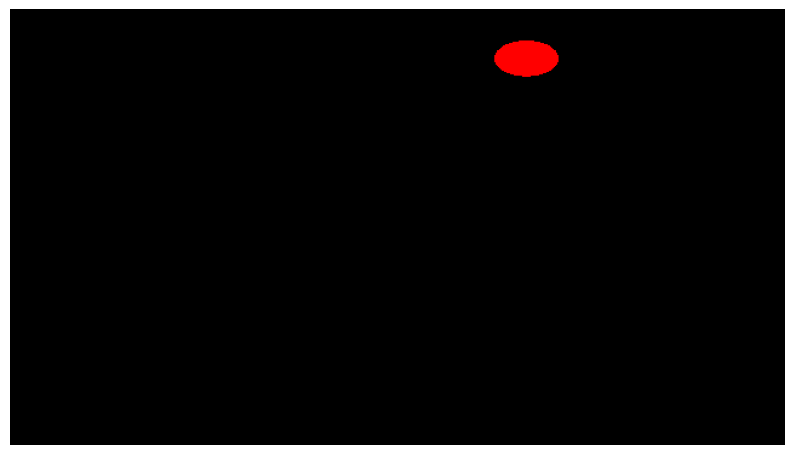

In [10]:
# Тест обратного преобразования
orig = labels_to_rgb([y])
plt.figure(figsize=(10, 6))
plt.imshow(orig[0])
plt.axis('off')
plt.show()

Чтобы не хранить в памяти большой объем данных сразу, будем использовать генератор.

In [11]:
# Генератор данных для обучения
def data_generator(files_list, batch_size):
    n = len(files_list) # Получаем количество элементов в списке файлов для обучения
    i = 0 # Задаем начальный индекс

    while True:

        X_data = [] # Массив для хранения изображений разностных изображений
        Y_data = [] # Массив для хранения масок

        for b in range(batch_size): # Пробегаем по всему batch_size

            if i==0: # Если первая итерация цикла
                np.random.shuffle(files_list) # Перемешиваем элементы

            # Получаем разностное изображение
            x = return_grayscale_image(files_list[i], SUBST_SUBDIR)

            # Добавляем ось
            x = np.expand_dims(x, axis = -1)

            # Добавляем в массив
            X_data.append(x)

            # Получаем соответствующую маску изображения и добавляем маску в массив
            Y_data.append(return_image(files_list[i], MASK_SUBDIR))

            # Обновляем значение индека (не превышая общего количества элементов)
            i = (i+1) % n


        # Преобразуем в numpy разностные изображения
        X_data = np.array(X_data)

        # Преобразуем сегментов в метки классов
        Y_data = rgb_to_labels(Y_data)

        yield X_data, Y_data

# Обучение нейронной сети

In [12]:
# Создание модели и вывод сводки по архитектуре
model_unet = unet(CLASS_COUNT,
                  (IMG_H, IMG_W, 1))

model_unet.summary()

# Вывод графической схемы архитектуры модели
#utils.plot_model(model_unet, dpi=80)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 640, 1)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 360, 640, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 360, 640, 64)         256       ['block1_conv1[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 360, 640, 64)         0         ['batch_normalization[0][0

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 0.0507 - sparse_categorical_accuracy: 0.9877
Epoch 1: val_loss improved from inf to 0.02883, saving model to unet_carpets_weights_Left.h5


/home/mikz/miniconda3/envs/streamlit_Tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 376s 928ms/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0288 - val_sparse_categorical_accuracy: 0.9909 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 0.0264 - sparse_categorical_accuracy: 0.9911
Epoch 2: val_loss improved from 0.02883 to 0.02674, saving model to unet_carpets_weights_Left.h5
359/359 [==============================] - 316s 880ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.0267 - val_sparse_categorical_accuracy: 0.9911 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 0.0236 - sparse_categorical_accuracy: 0.9919
Epoch 3: val_loss improved from 0.02674 to 0.02486, saving model to unet_carpets_weights_Left.h5
359/359 [==============================] - 316s 880ms/step - loss: 0.0236 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.0249 - val_sparse_categorical_accuracy: 0.9923 - lr: 0.0010
Epoch 4/100
359/

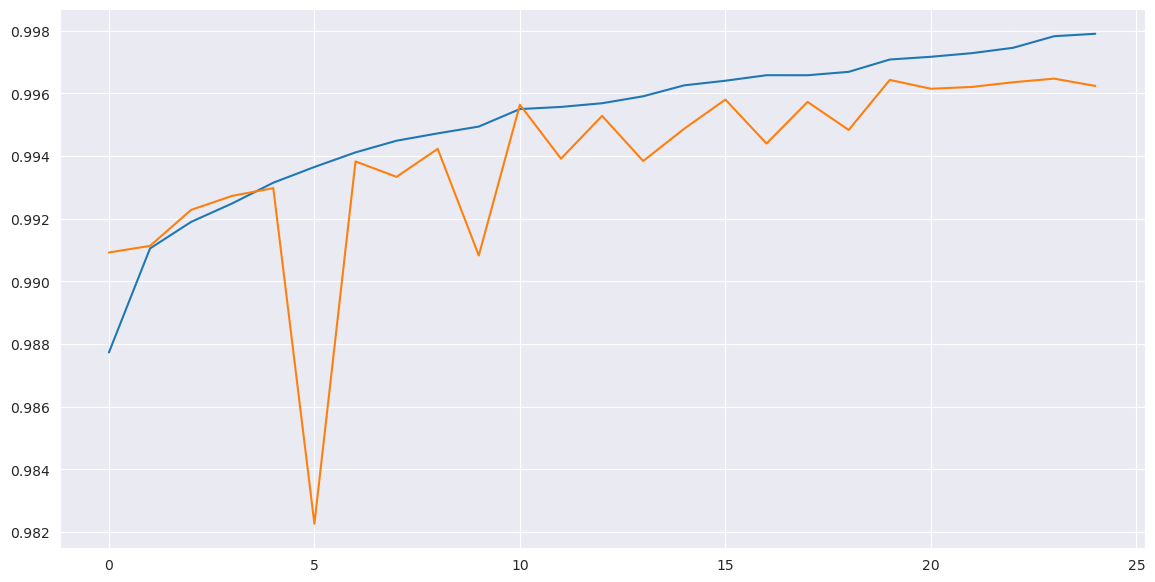

In [13]:
# Задаем путь для сохранения весов модели
weights_path = 'unet_carpets_weights_Left.h5'
if os.path.exists(weights_path):
    model_unet.load_weights(weights_path)
# Задаем размер батча
batch_size = 8

# Количество эпох
epochs = 100          # 10 установлено для теста ноутбука

# Задаем Колбэки
# Cохранение весов модели в случае улучшения результата
model_Checkpoint = ModelCheckpoint(filepath=weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', baseline=0.5)
# Корректировка шага обучения при отсутствии прогресса
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, verbose=1)
# Остановка - если не растет точность
earlystop = EarlyStopping( monitor="val_loss",
    min_delta=0.,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=11)

# Запускаем процесс обучения на 100 эпохах
history = model_unet.fit(data_generator(Files_Train, batch_size),
                         steps_per_epoch = max (1, len(Files_Train)//batch_size),
                         validation_data = data_generator(Files_Val, batch_size),
                         validation_steps = max (1, len(Files_Val)//batch_size), epochs = epochs, verbose = 1, initial_epoch = 0,
                         callbacks=[model_Checkpoint, reduceLROnPlateau, earlystop])


# Отображение графиков обучения модели
plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()